<a href="https://colab.research.google.com/github/JP109/Supervised-Learning-Algorithms-practise/blob/main/Classification%20Algorithms/Gaussian_Naive_Bayes_on_Santander_Customer_Transaction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this kernel, we will apply Bayesian inference on Santander Customer Transaction data, which has a binary target and 200 continuous features.

## **Checking Assumptions**
The classifier has already been implemented by scikit-learn, so we can use it right away. But we have to make sure that our assumptions hold, i.e., the likelihood distributions are normal and independent.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10, 10)
title_config = {'fontsize': 20, 'y': 1.05}

In [ ]:
from google.colab import files
training_dataset = files.upload()

Saving train.csv to train.csv


In [ ]:
train=pd.read_csv('train.csv')
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
train.shape

(200000, 202)

In [ ]:
X_train = train.iloc[:, 2:].values.astype('float64')
y_train = train['target'].values

We will look at the likelihood distributions by plotting the KDE (Kernel Density Estimates) using the pandas.DataFrame.plot.kde. 

Note that KDE is a similarity-based method so it gets slower with more data. We can speed up by reducing the number of evaluation points (ind parameter), but this also decreases the resolution of the plot.

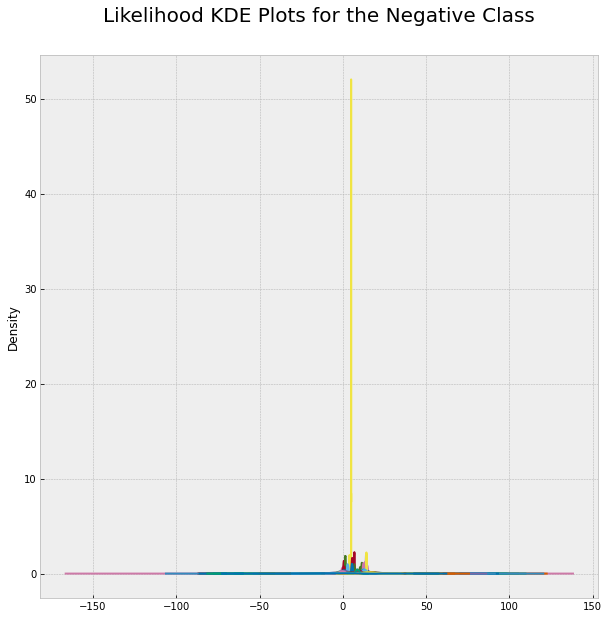

In [ ]:
pd.DataFrame(X_train[y_train == 0]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class', **title_config);

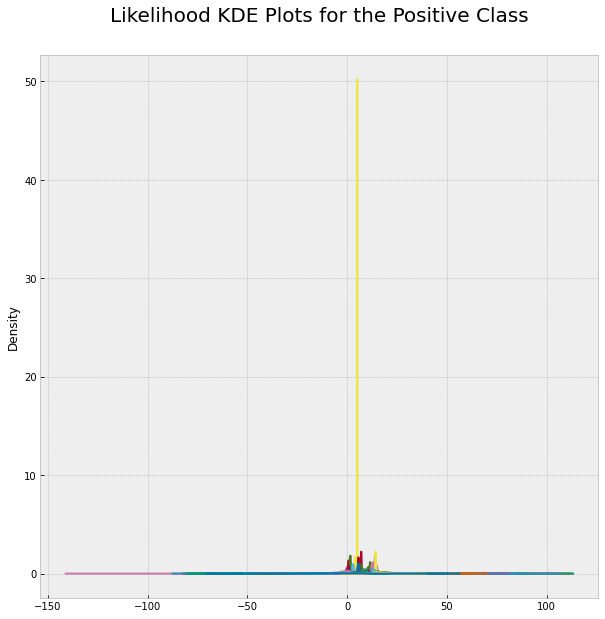

In [ ]:
pd.DataFrame(X_train[y_train == 1]).plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class', **title_config);

The KDE plots above suggest that the likelihood distributions have different centers and spread. 

We will standardize them (subtract mean and divide by standard deviation) so that they have zero mean and unit variance. We can use sklearn.preprocessing.StandardScaler for standardization.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaled = pd.DataFrame(StandardScaler().fit_transform(X_train))

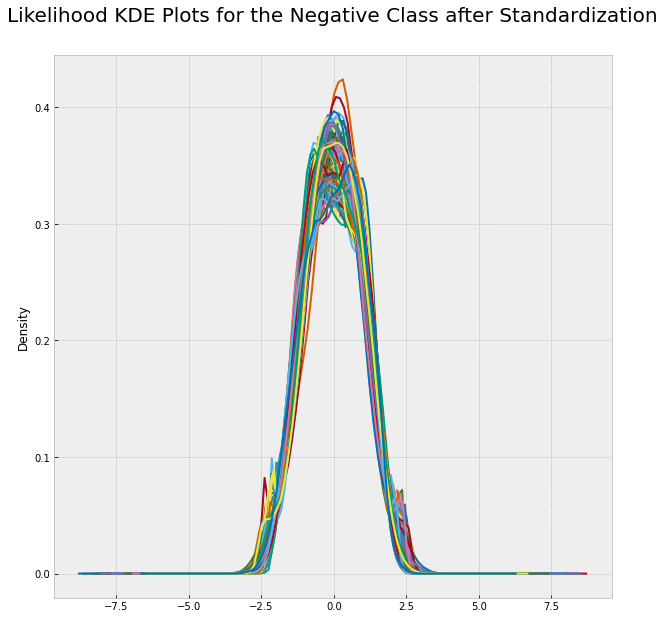

In [ ]:
scaled[y_train == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Standardization', **title_config);

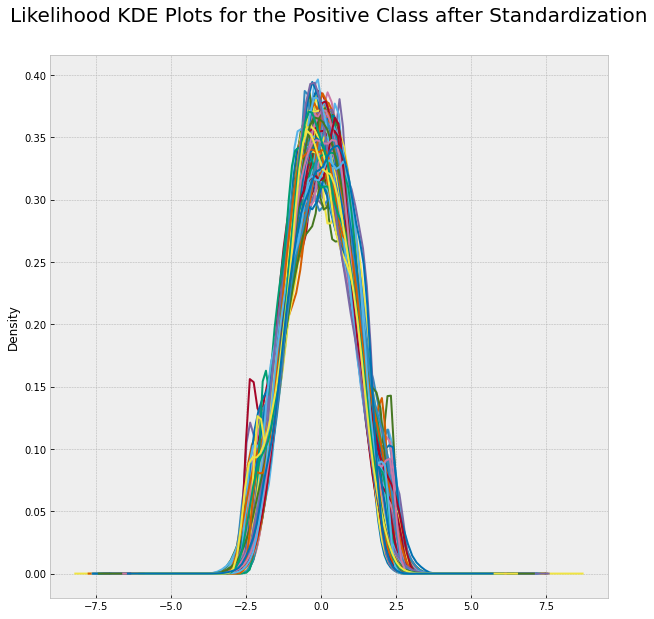

In [ ]:
scaled[y_train == 1].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class after Standardization', **title_config);

Now the KDE plots above look approximately normal, but some have small bumps on the left or right. We can proceed without doing anything, or we can use quantile transformation to remove the small bumps. It turns out that the transformation provides only marginal improvement in performance (0.001 in cross-validation AUC) despite requiring significantly more computation. In practice, we might choose to skip the transformation. In this competition, however, we will do the transformation for that tiny improvement.

Ideally, we need to apply the transformation to the features separately for the positive and negative classes. However, we cannot because it becomes a trouble when we are predicting the test data (we do not know the target value). We will instead apply it to the features as a whole so what we really get are normal unconditional distributions  fXi  instead of normal conditional distributions  fXi|Y , but we hope that the conditional distributions will become more normal as well. We can use sklearn.preprocessing.QuantileTransformer for quantile transformation.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(X_train))

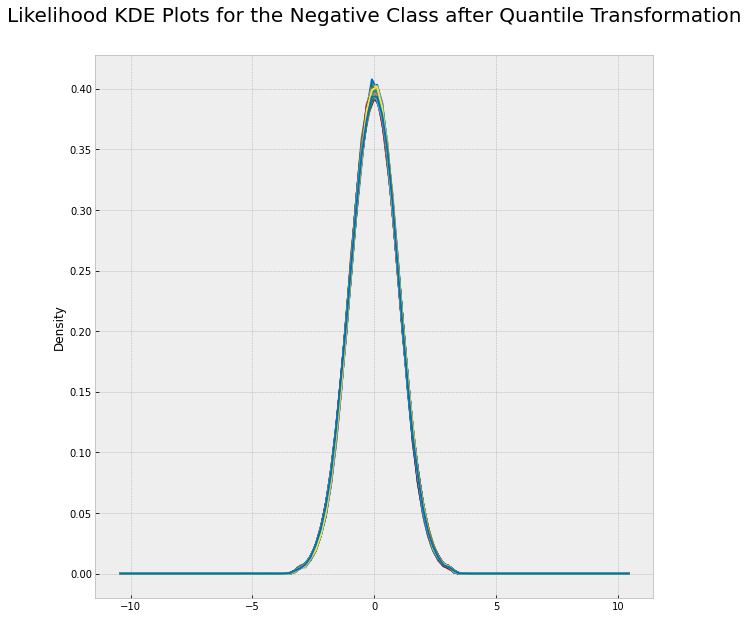

In [ ]:
transformed[y_train == 0].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Negative Class after Quantile Transformation', **title_config);

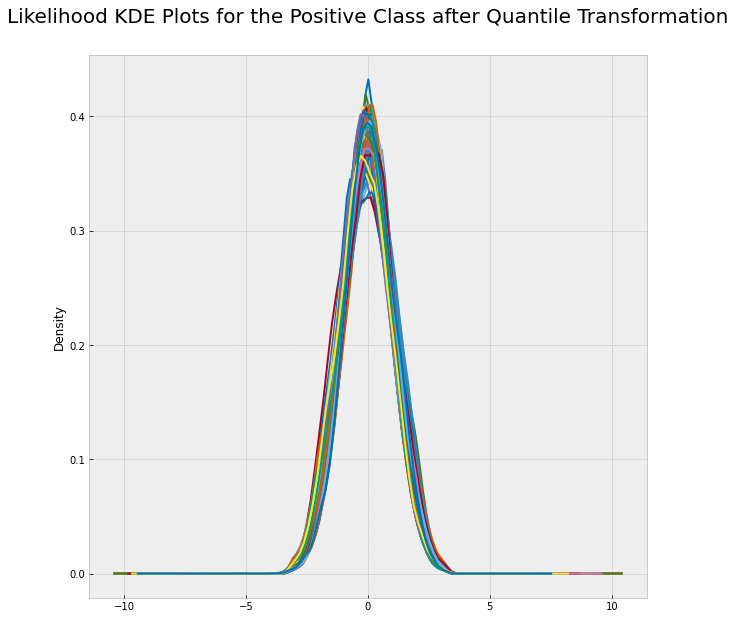

In [ ]:
transformed[y_train == 1].plot.kde(ind=100, legend=False)
plt.title('Likelihood KDE Plots for the Positive Class after Quantile Transformation', **title_config);

In the KDE plots above, the likelihood distributions have become normal as we desire.

Independence is difficult to check, but we can check the sample correlation coefficients. Small correlation coefficients mean that there is a weak linear pattern. We visualize the correlation matrix by using matplotlib.pyplot.imshow.

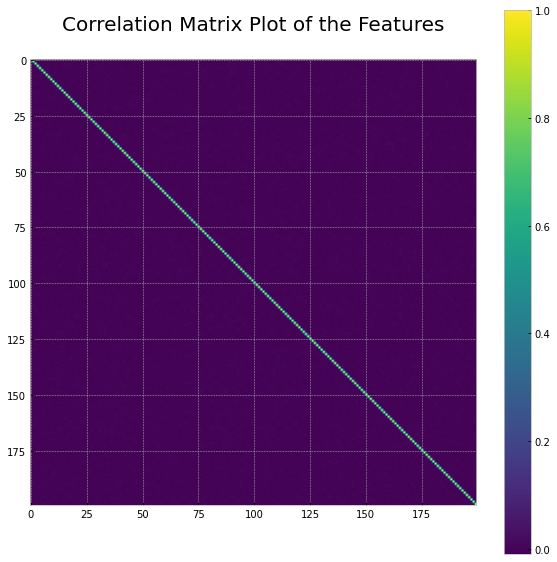

In [ ]:
plt.imshow(transformed.corr())
plt.colorbar()
plt.title('Correlation Matrix Plot of the Features', **title_config);

The correlation matrix plot above shows very small correlation coefficients between the features.

Finally, it is important that  Y  is dependent on  X . If  X  and  Y  were independent, then the posterior would be equal to the prior  pY|X(y|x)=pY(y) , and we would not need to do any calculation! We have already seen above that the positive and negative likelihood distributions are slightly different. Let us look at how the sample means and sample variances differ.

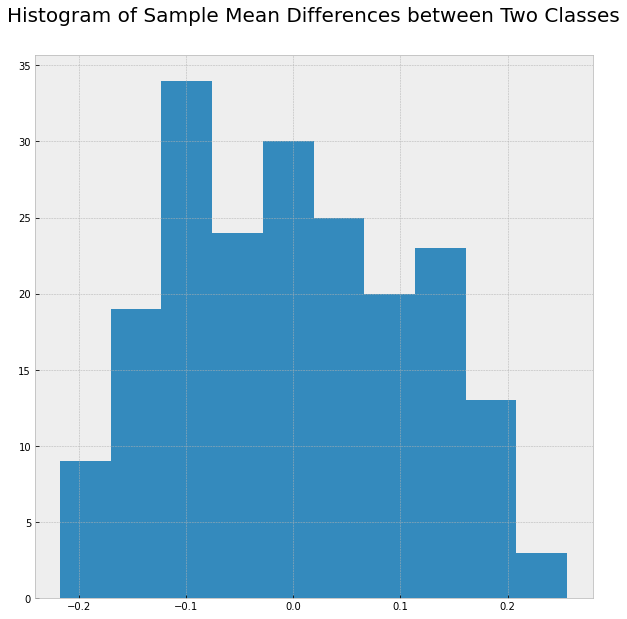

In [ ]:
plt.hist(transformed[y_train == 0].mean() - transformed[y_train == 1].mean())
plt.title('Histogram of Sample Mean Differences between Two Classes', **title_config);

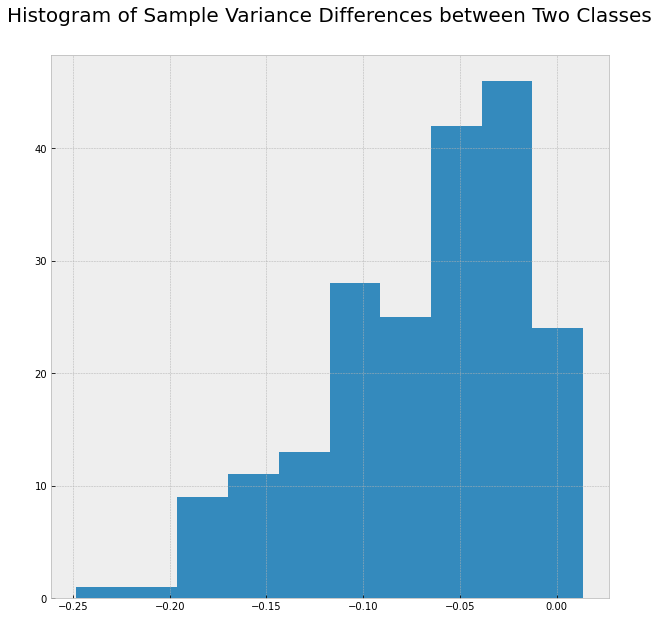

In [ ]:
plt.hist(transformed[y_train == 0].var() - transformed[y_train == 1].var())
plt.title('Histogram of Sample Variance Differences between Two Classes', **title_config);

While the sample mean differences are more or less balanced around zero, the sample variance differences are almost entirely on the negative side. This means that the negative likelihood distributions are more concentrated around their means than the positive ones. These differences add to the discriminative power of the model. The further away the centers of the distributions or the greater the difference in the spread of the distributions, the more it can tell about which class the point is coming from.

If there are features  Xi  such that the likelihood distributions are equal —  fXi|Y(xi|0)=fXi|Y(xi|1) , their densities will cancel in the numerator and the denominator. These features do not help in classification. So, in some sense, the Bayes classifier performs automatic feature selection.

Now I have the following puzzle. The plot below shows two features with the least sample variance difference (greatest absolute difference where the variance of the positive class is higher). Surprisingly, the negative class looks more spread out despite having lower sample variance than the positive class.

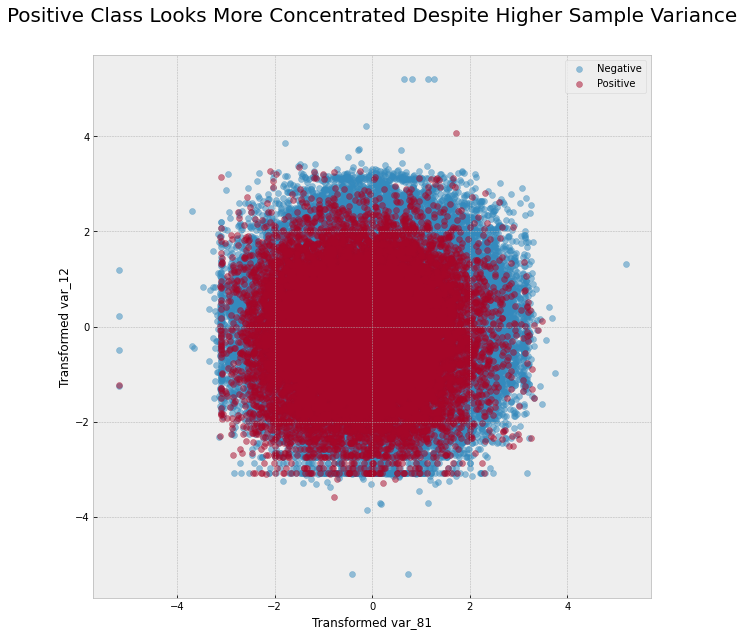

In [ ]:
select = (transformed[y_train == 0].var() - transformed[y_train == 1].var()).nsmallest(2).index
plt.scatter(transformed.loc[y_train == 0, select[0]], transformed.loc[y_train == 0, select[1]], alpha=0.5, label='Negative')
plt.scatter(transformed.loc[y_train == 1, select[0]], transformed.loc[y_train == 1, select[1]], alpha=0.5, label='Positive')
plt.xlabel(f'Transformed var_{select[0]}')
plt.ylabel(f'Transformed var_{select[1]}')
plt.title('Positive Class Looks More Concentrated Despite Higher Sample Variance', **title_config)
plt.legend();

Why? Let us look at the sample mean differences

In [ ]:
transformed.loc[y_train == 0, select[0]].mean() - transformed.loc[y_train == 1, select[0]].mean()

0.25551648397382937

In [ ]:
transformed.loc[y_train == 0, select[1]].mean() - transformed.loc[y_train == 1, select[1]].mean()

0.22585953578787682

The center of the negative class is above and to the right of that of the positive class, but in the above plot, we see straight lines on the lower and left edges. The bounds have remained even after quantile transformation. It looks like these bounds have prevented the positive class from expanding to the lower and left sides. The bounds are more obvious when you look at the original data.

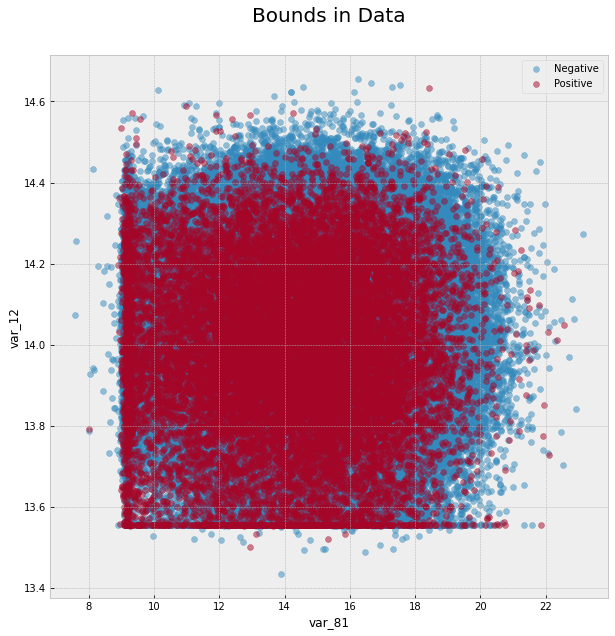

In [ ]:
plt.scatter(X_train[y_train == 0, select[0]], X_train[y_train == 0, select[1]], alpha=0.5, label='Negative')
plt.scatter(X_train[y_train == 1, select[0]], X_train[y_train == 1, select[1]], alpha=0.5, label='Positive')
plt.xlabel(f'var_{select[0]}')
plt.ylabel(f'var_{select[1]}')
plt.title('Bounds in Data', **title_config)
plt.legend();

Despite the presence of bounds, we are going to assume that the transformed data is normal and proceed anyway. We can sample data from normal distributions using np.random.normal and plot them for comparison.

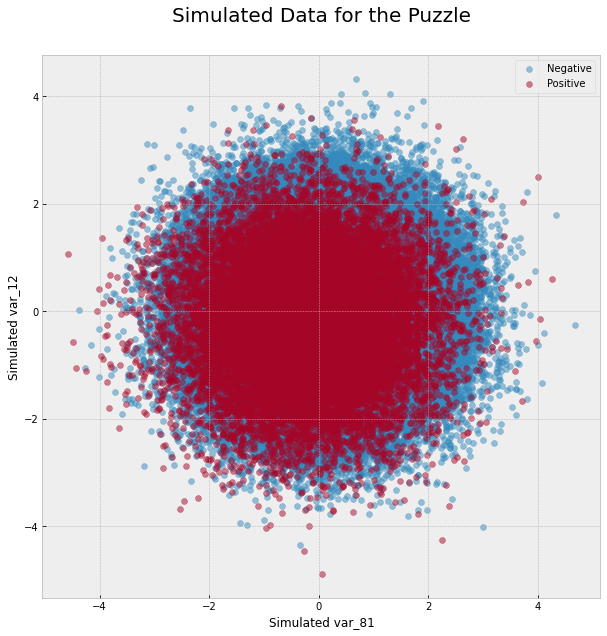

In [ ]:
size0 = (y_train == 0).sum()
size1 = y_train.size - size0
x0 = np.random.normal(transformed.loc[y_train == 0, select[0]].mean(),
                      transformed.loc[y_train == 0, select[0]].std(), size=size0)
y0 = np.random.normal(transformed.loc[y_train == 0, select[1]].mean(),
                      transformed.loc[y_train == 0, select[1]].std(), size=size0)
x1 = np.random.normal(transformed.loc[y_train == 1, select[0]].mean(),
                      transformed.loc[y_train == 1, select[0]].std(), size=size1)
y1 = np.random.normal(transformed.loc[y_train == 1, select[1]].mean(),
                      transformed.loc[y_train == 1, select[1]].std(), size=size1)
plt.scatter(x0, y0, alpha=0.5, label='Negative')
plt.scatter(x1, y1, alpha=0.5, label='Positive')
plt.xlabel(f'Simulated var_{select[0]}')
plt.ylabel(f'Simulated var_{select[1]}')
plt.title('Simulated Data for the Puzzle', **title_config)
plt.legend();

We see above that the positive class spreads more to the lower and left sides than the negative class. Another reason for the illusion is that we have far fewer positive points than negative points.

## Training and Evaluating the Model

Now we are ready to train our model. We combine the quantile transformer and Gaussian naive Bayes classifer, sklearn.naive_bayes.GaussianNB, into a pipeline using sklearn.pipeline.make_pipeline.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

After training the model, we plot the ROC curve on training data and evaluate the model by computing the training AUC and cross-validation AUC. We can use sklearn.metrics.roc_curve to obtain the values for plotting the curve and sklearn.metrics.auc for computing the AUC.

0.8911029458228303

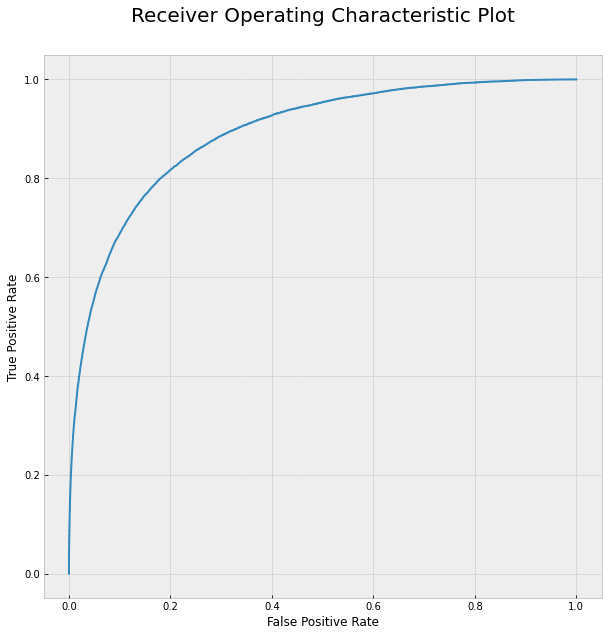

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_train, pipeline.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

We compute the 10-fold cross-validation score by using sklearn.model_selection.cross_val_score.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8894127634963729

We achieved good AUC on both training and cross-validation. But is this the best that this model can achieve? Let us use simulation to get an estimate of the optimal AUC that this model can achieve. We will draw samples from the normal distribution with the 800 parameters of the likelihood. The amount of samples to draw from each class will be determined by the prior so that the classes have the same proportions as the training data.

In [ ]:
from sklearn.metrics import roc_auc_score

pipeline.fit(X_train, y_train)
model = pipeline.named_steps['gaussiannb']
size = 1000000
size0 = int(size * model.class_prior_[0])
size1 = size - size0
sample0 = np.concatenate([[np.random.normal(i, j, size=size0)]
                          for i, j in zip(model.theta_[0], np.sqrt(model.sigma_[0]))]).T
sample1 = np.concatenate([[np.random.normal(i, j, size=size1)]
                          for i, j in zip(model.theta_[1], np.sqrt(model.sigma_[1]))]).T
X_sample = np.concatenate([sample0, sample1])
y_sample = np.concatenate([np.zeros(size0), np.ones(size1)])
roc_auc_score(y_sample, model.predict_proba(X_sample)[:,1])

0.8897715379253281

We see that the optimal AUC under the model is not much different from the cross-validation AUC.

Conclusion
The Gaussian naive Bayes classifier performs quite well on Santander Customer Trasaction data. This is because the normality and independence assumptions are closely followed by the data. We have seen that even if the data have been generated by independent normal distributions (according to the model trained on transformed data), we cannot get a better AUC. However, there may still be some other transformation that can improve our model. In my opinion, the normality assumption is not very realistic since some features seem to have lower and upper bounds.

One can also remove the assumptions and try to use density estimation techniques to model the likelihood distributions. KDE is not very tractable on data of this size. We can also use a Gaussian mixture model or a multivariate normal distribution with the sample covariance matrix from the data. In my experience, they give better training AUC but worse cross-validation AUC. The Gaussian naive Bayes classifier (improved a little bit by quantile transformation) is currently the best Bayesian model for the data.